In [1]:
from Models.functions.datasets import getDatasets, load
from Models.functions.plot import ROC, plot_confusion_matrix
#from Models.baseline3.main import run

In [ ]:
#!pip install keras
#!pip install tensorflow

In [ ]:
import keras, os, pickle, re, sklearn, string, tensorflow
print('Keras version: \t\t%s' % keras.__version__)
print('Scikit version: \t%s' % sklearn.__version__)
print('TensorFlow version: \t%s' % tensorflow.__version__)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

### Parameter

In [ ]:
# EMBEDDING
MAX_NUM_WORDS  = 50000 #15000
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 3200 #200
USE_GLOVE      = False

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 20
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.2

In [2]:
task = 'gender'
dataset_name = 'b5post'
root = "/home/rafael/USP/drive/Data/Dataframe/"

X_train, y_train, _, _ = load(task, dataset_name, root)

ValueError: not enough values to unpack (expected 4, got 0)

### Preprocessing

In [ ]:
def labelEncoder(y):
    le = LabelEncoder()
    le.fit(y)

    return (le.transform(y), len(le.classes_), list(le.classes_))

def clean(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Removing short words
    """
    stop_words = set(stopwords.words('portuguese'))
    
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def read_files(path):
    documents = list()
    # Read in all files in directory
    if os.path.isdir(path):
        for filename in os.listdir(path):
            with open('%s/%s' % (path, filename)) as f:
                doc = f.read()
                doc = clean_doc(doc)
                documents.append(doc)
    
    # Read in all lines in a txt file
    if os.path.isfile(path):        
        with open(path, encoding='iso-8859-1') as f:
            doc = f.readlines()
            for line in doc:
                documents.append(clean_doc(line))
    return documents

In [ ]:
task = 'age'
dataset_name = 'b5post'

datasets = getDatasets(task,'df', dataset_name)
for i in datasets.iterrows():

    name = i[1]['dataset_name']
    label = task
    ds_path = i[1]['path']

    # load training and test dataframes
    training_path = ds_path + '/' + i[1]['training']        
    #test_path = ds_path + '/' + i[1]['test']      

    df_training = pd.read_csv(training_path)#, usecols=cols)        
    #df_test = pd.read_csv(test_path)#, usecols=cols)        

    df_training['text'] = df_training['text'].apply(clean)
    #df_test['text'] = df_test['text'].apply(clean)
    #X = df_training['text'].values
    #y, n_classes, classes_name = labelEncoder(df_training[label].values)


In [ ]:
len(df_training)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print('Training samples: %i' % len(y))
# print('Test samples: %i' % len(y_test))

## Tokenizer

In [110]:
def max_length(lines):
    """
    Calculate the maximum document length
    """
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [111]:
length = max_length(X)
word_index = tokenizer.word_index

result = [len(x.split()) for x in X]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 1249820 / min length: 50 / mean length: 6455 / limit length: 3200
vocabulary size: 1140241 / limit: 50000


## Embeddings

In [112]:
def create_glove_embeddings():
    print('Pretrained embeddings GloVe is loading...')

    #embeddings_index = {}
    #glove_path = '/home/rafael/embeddings/glove.840B.300d.txt'
    #f = open('glove.6B.%id.txt' % EMBEDDING_DIM)
    #f = open(glove_path)
    #for line in f:
        #values = line.split()
        #word = values[0]
        #coefs = np.asarray(values[1:], dtype='float32')
        #embeddings_index[word] = coefs
    #f.close()
    
    embeddings_index = {}        
    f = open(r'/home/rafael/embeddings/wiki.en.vec', encoding='utf8')
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

## Tfidf

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(max_features=100)
#X_train_tfidf = vec.fit_transform(X).toarray()
#print(type(X_train_tfidf),X_train_tfidf.shape) 

## Model definition

## Training

In [ ]:
import cnn_model
def create_model():
    
    model = cnn_model.build_cnn(
            embedding_layer=emb_layer,
            num_words=MAX_NUM_WORDS,
            embedding_dim=EMBEDDING_DIM,
            filter_sizes=FILTER_SIZES,
            feature_maps=FEATURE_MAPS,
            max_seq_length=MAX_SEQ_LENGTH,
            dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
            loss='binary_crossentropy',
            optimizer=Adadelta(clipvalue=3),
            metrics=['accuracy']
    )
    return model

model = KerasClassifier(build_fn=create_model, batch_size=1000, epochs=10) 

########################################################
# Use scikit-learn to grid search 
#activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#weight_constraint=[1, 2, 3, 4, 5]
#neurons = [1, 5, 10, 15, 20, 25, 30]
#init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
##############################################################
# grid search epochs, batch size
epochs = [1, 1] # add 50, 100, 150 etc
batch_size = [10,20] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)
##############################################################
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, y) 
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/home/rafael/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Vocabulary size: 50000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 3200
#############################################
Epoch 1/1
10304/10304 [==============================] - 142s 14ms/step
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Vocabulary size: 50000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 3200
#############################################
Epoch 1/1
10304/10304 [==============================] - 143s 14ms/step
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Vocabulary size: 50000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 3200
#############################################
Epoch 1/1
10304/10304 [==============================] - 144s 14ms/ste

In [120]:
import cnn_model
from sklearn.model_selection import StratifiedKFold

histories = []
test_loss = []
test_accs = []

predicted_y = []
expected_y = []

#K = StratifiedKFold(n_splits=2)

X_train_, X_val, y_train_, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

emb_layer = None
#if USE_GLOVE:
    #emb_layer = create_glove_embeddings()



history = model.fit(
    X_train, y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('model-%i.h5', monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01),
               #EarlyStopping(monitor='val_loss', min_delta=0.1, patience=4, verbose=1)
              ]
)
print()

score = model.evaluate(X_test, y_test, verbose=1)
test_loss.append(score[0])
test_accs.append(score[1])

y_pred = model.predict(X_test, verbose=1)

predicted_y.extend(y_pred)
expected_y.extend(y_test)


histories.append(history.history)

Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Vocabulary size: 50000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 3200
#############################################


KeyboardInterrupt: 

In [74]:
with open('history.pkl', 'wb') as f:
    pickle.dump(histories, f)

## Evaluation

In [124]:
histories = pickle.load(open('history.pkl', 'rb'))

### Test

In [ ]:
expected_y2 = np.asarray(expected_y)
predicted_y2 = np.asarray(predicted_y).round()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

report = pd.DataFrame(classification_report(expected_y2, predicted_y2, digits=5, target_names=classes_name, output_dict=True))
report = report.transpose()
accuracy = accuracy_score(expected_y2, predicted_y2)
report['accuracy'] = [accuracy] * (n_classes + 3)
display(report)

roc_c = ROC(expected_y2, score_y, n_classes, task, dataset_name, classes_name)
report['roc'] = list(roc_c.values()) + [roc_c['macro']] * 2

# compute accuracy
accuracy = accuracy_score(expected_y2, predicted_y2)
report['accuracy'] = [accuracy] * (n_classes + 3)

# compute confusion matrix
c_matrix = confusion_matrix(expected_y2, predicted_y2)
plot_confusion_matrix(c_matrix, classes_name, task, dataset_name, True)
cm = pd.DataFrame(c_matrix, columns=classes_name, index=classes_name)

directory = './Reports/' + task + '/' + dataset_name + '/'
report.to_csv(directory + 'report.csv')
cm.to_csv(directory + 'confusion_matrix.csv')    

In [180]:
task, dataset_name
import matplotlib.pyplot as plt


In [181]:
#roc_c = ROC(expected_y, score_y, n_classes, task, dataset_name, classes_name)
#report['roc'] = list(roc_c.values()) + [roc_c['macro']] * 2
# compute confusion matrix
c_matrix = confusion_matrix(expected_y2, predicted_y2)
plot_confusion_matrix(c_matrix, classes_name, task, dataset_name, True)
plot_confusion_matrix(c_matrix, classes_name, task, dataset_name, False)

Normalized confusion matrix
[[0.66428571 0.33571429]
 [0.19500403 0.80499597]]
Confusion matrix, without normalization
[[558 282]
 [242 999]]


<Figure size 432x288 with 0 Axes>

### Train

In [172]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

#print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

Training: 	0.4419 loss / 0.8240 acc
Validation: 	0.5963 loss / 0.7487 acc


In [121]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    
    for i, m in enumerate(histories):        
        ax1.plot(m[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')        
    ax1.legend(names, loc='lower right')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for m in histories:
        ax2.plot(m[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

In [175]:
def plot_loss(histories):
    
    train_loss = 'loss'
    val_loss = 'val_loss'
    
    fig, ax2 = plt.subplots(1)
    names = []
    names.append('Training')
    names.append('Validation')
    
    # Loss
    ax2.set_title('Model loss')
    for m in histories:
        # training
        ax2.plot(m[train_loss])
        ax2.set_xlabel('epoch')
        
        ax2.set_ylabel('loss')
        
        # validation
        ax2.plot(m[val_loss])
        ax2.set_xlabel('epoch')
        
        ax2.set_ylabel('loss')
        
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

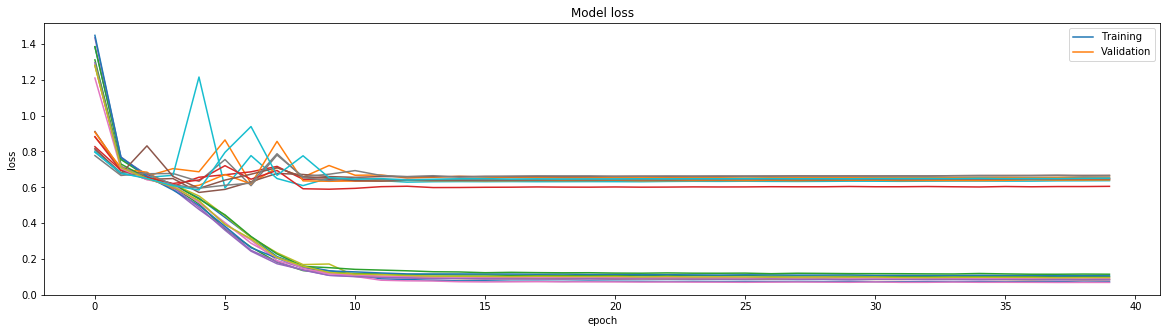

In [176]:
#plot_acc_loss('training', histories, 'acc', 'loss')
plot_loss(histories)

##### Final test (Test1 / Test2)

In [ ]:
X_test = docs_test
X_test2 = docs_test2
#y_test = [0 for _ in range(len(negative_docs_test))] + [1 for _ in range(len(positive_docs_test))]

In [ ]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

sequences_test2 = tokenizer.texts_to_sequences(X_test2)
X_test2 = pad_sequences(sequences_test2, maxlen=MAX_SEQ_LENGTH, padding='post')

In [ ]:
test_loss = []
test_accs = []

RUNS = 1

for i in range(0,RUNS):
    cnn_ = load_model("model-%i.h5" % (i+1))
    
    score = cnn_.evaluate(X_test, y_test, verbose=1)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def predictTest(model, X_test, y_test):
    y_pred = model.predict(X_test, verbose=1)
    cm = confusion_matrix(y_test, y_pred.round()) 
    print("Confusion Matrix")
    print(cm)
    print("Report")
    print(classification_report(y_test, y_pred.round()))

In [ ]:
predictTest(model, X_test, y_test)

In [ ]:
test_loss = []
test_accs = []

RUNS = 1

for i in range(0,RUNS):
    cnn_ = load_model("model-%i.h5" % (i+1))
    
    score = cnn_.evaluate(X_test2, y_test2, verbose=1)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

In [ ]:
predictTest(model, X_test2, y_test2)